# `mesmer` example

`mesmer` is a foreground component separation code. It is centered around a `LogProb` object which calculates the posterior of foreground spectral parameters in a given model, marginalized over the foreground amplitudes. In this model, all ampltidue terms are Gaussian-distributed, and so can be sampled with 100% acceptance rate once the marginal distribution of spectral parameters is calculated.

For demonstration purposes we will generate some fake data, and calculate the posterior foreground parameters using `mesmer.LogProb`.

First we set up some simple fake data with the `fake_data` function below. This data simulates observations at `nfreq` frequencies, with white noise at all frequencies with a pixel RMS of `sens=4`. The signal component is taken to be a sum of dust, synchrotron, and CMB, all with spatially uniform emission, and spatially uniform spectral dependency. Therefore, teh data is correctly modeled by the parametric model in `LogProb`.

In [1]:
import mesmer
import jax
import matplotlib.pyplot as plt

true_beta_s = -3.
true_beta_d = 1.5
true_params = jax.numpy.array([true_beta_d, true_beta_s])

def fake_data(beta_s, beta_d):
    """ Generate fake data.
    """
    # import numpy only in this scope, as we don't want to get confused with jax's numpy.
    import numpy as np

    nfreq = 13
    sens = 4.
    npix = 100

    dust_template = 100. * np.ones((1, 2, npix))
    freq_d = 353.
    T_d = 20.

    sync_template = 5 * np.ones((1, 2, npix))
    freq_s = 23.

    cmb_template = 10. * np.ones((1, 2, npix))

    freq_obs = np.array([10., 23., 30., 40., 95., 100., 145., 220., 270., 300., 353., 545, 800])
    assert len(freq_obs) == nfreq
    sensitivities = np.array([sens] * nfreq)


    hnkt_ref = 0.0479924466 * freq_d / T_d
    dust_fn = lambda nu: (nu / freq_d) ** (beta_d + 1) * (np.exp(hnkt_ref) - 1) / (np.exp(0.0479924466 * nu / T_d) - 1)
    sync_fn = lambda nu: (nu / freq_s) ** (beta_s)
    cmb_fn = lambda nu: np.exp(0.0176086761 * nu) * (0.0176086761 * nu / (np.exp(0.0176086761 * nu) - 1)) ** 2

    dust_scaling = np.array(list(map(dust_fn, freq_obs)))
    dust_scaled = dust_scaling[:, None, None] * dust_template

    sync_scaling = np.array(list(map(sync_fn, freq_obs)))
    sync_scaled = sync_scaling[:, None, None] * sync_template

    cmb_scaling = np.array(list(map(cmb_fn, freq_obs)))
    cmb_scaled = cmb_scaling[:, None, None] * cmb_template

    data = dust_scaled + cmb_scaled + sync_scaled
    covariance=np.ones((nfreq, 2, npix)) * sensitivities[:, None, None] ** 2

    noise = np.random.randn(nfreq, 2, npix) * np.sqrt(covariance)
    data += noise

    templates=(dust_template, sync_template, cmb_template)
    scaled_maps = (dust_scaled, sync_scaled, cmb_scaled)

    return (freq_obs, beta_s, beta_d, templates, scaled_maps, data, covariance)

frequencies, true_beta_s, true_beta_d, templates, scaled_maps, data, covariance = fake_data(true_beta_s, true_beta_d)

/home/bthorne/.cache/pypoetry/virtualenvs/mesmer-7PBZ4nd--py3.8/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Model definition

Next we define the model to fit. Each key of the `model` dictionary corresponds to a function name, as defined in `mesmer.seds`. The whichever arguments to these functions are to be fixed must be specified as a subdictionary, as shown. Whichever parameters are to be varied are also specified in a separate subdictionary, and a prior is specified by a tuple containing `(mean, std)`.

In [2]:
model = {
        'dustmbb': {
            'varied': { # here we specify a Gaussian prior of 0.5 standard deviation around the true beta_d value
                'beta_d': [true_beta_d, 0.5]
            }, # we fix the other two parameters of the dust SED.
            'fixed': {
                'T_d': 20.,
                'nu_ref_d': 353.,
            }
        },
        'syncpl': {
            'varied': {
                'beta_s': [true_beta_s, 0.5]
            },
            'fixed': {
                'nu_ref_s': 23.,
            }
        }, # although the CMB has no parameters, the model will currently expect these keywords to be present. This needs to be fixed.
        'cmb': {
            'varied': {
            },
            'fixed': {
            }
        },
    }

## `mesmer.LogProb` instantiation

The `LogProb` object is then instantiated with the data, the pixel covariance, the frequencies at which this data is taken, and the model dictionary.

The `data` is assumed to have shape `(nfreq, npol, npix)`, where `npix` is the pixel dimension, which can be a HEALPix map, or a flattened two dimensional map. 

The `covariance` must have the same shape as the data, and contains the noise variance in each pixel. The model assumes noise is uncorrelated between pixels and between channels.

The `frequencies` value is an array containing the frequencies observed, in GHz.

The `model` value is the dictionary we have specified above.

In [3]:
logprob = mesmer.LogProb(data=data, covariance=covariance, frequencies=frequencies, model=model)
# check which parameters are free, and the assumed ordering when calling the `LogProb` object.
print(logprob.free_parameters)

['beta_d', 'beta_s']


## Maximum Likelihood Estimation

We can estimate the maximum likelihood spectral parameters by maximizing `LogProb`. We can use the `ret_neg` flag to return the negative log probability, and so use `scipy`'s `minimize` routine.

In [4]:
from scipy.optimize import minimize

In [5]:
min_res = minimize(logprob, true_params, tol=1e-9, args=(True), method='Powell')

In [6]:
try:
    assert min_res.success
    print(f"Successfully minimized, result: {min_res.x}")
except AssertionError:
    raise AssertionError("Did not optimize successfully.")

Successfully minimized, result: [ 1.5027626 -2.8763366]


With autograd, we can also calculate the Hessian of the likelihood at this point in parameter space to get an estimate of the uncertainties.

In [7]:
hessian = jax.jacfwd(jax.jacrev(logprob))
hessian_eval = hessian(min_res.x, True)
print("Hessian evaluated", hessian_eval)

fish_est = jax.numpy.linalg.inv(hessian_eval)
print("Fishers estimates of uncertainty: ", jax.numpy.sqrt(fish_est[0, 0]), jax.numpy.sqrt(fish_est[1, 1]))

Hessian evaluated [[176363.56      2317.1653 ]
 [  2317.1614     184.01591]]
Fishers estimates of uncertainty:  0.0026065595 0.08069458


## Hamiltonian Monte Carlo

Since `mesmer` uses the `jax`, we can also use the `tensorflow` samplers that are built on `jax`. This is still an experimental feature of Tensorflow Probability, and is likely to break at some point in the future. The `jax`-backed samplers are only available when using the `tf-nightly` and `tfp-nightly` builds. 

In this section we use an "out-of-the-box" Hamiltonian Monte Carlo sampler to demonstrate the idea. This is total overkill for the two-parameter model we are considering here.

In [8]:
from tensorflow_probability.python.internal.backend import numpy as tf
import tensorflow_probability as tfp; tfp = tfp.substrates.jax

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(2e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=logprob,
        num_leapfrog_steps=5,
        step_size=.05),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

rng = jax.random.PRNGKey(124)

In [9]:
# Run the chain (with burn-in).
@tf.function
def run_chain():
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=true_params,
        kernel=adaptive_hmc,
        seed=rng,trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    sample_mean = tf.reduce_mean(samples)
    sample_stddev = tf.math.reduce_std(samples)
    is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
    return sample_mean, sample_stddev, is_accepted, samples

sample_mean, sample_stddev, is_accepted, samples = run_chain()

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(sample_mean, sample_stddev, is_accepted))

mean:-0.6939  stddev:2.1966  acceptance:0.5294


Let's visualize the trace of each parameters. Clearly, the $\beta_s$ samples are highly correalted, whereas the $\beta_d$ samples are well converged.

Text(0.5, 0, 'Step')

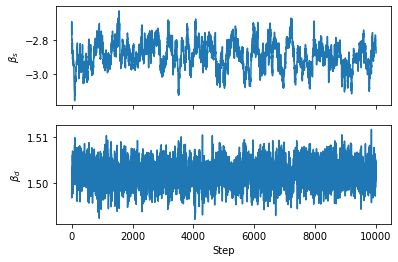

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(samples[:, 1])
ax[0].set_ylabel(r"$\beta_s$")
ax[1].plot(samples[:, 0])
ax[1].set_ylabel(r"$\beta_d$")
ax[1].set_xlabel(r"Step")

In [11]:
print(jax.numpy.mean(samples, axis=0))

[ 1.50204   -2.8897474]


We can now plot histograms of the HMC samples, and compare them to the posteriors deduced by maximizing the posterior, and computing the Hessian using `jax`'s forward / backward Jacobian operators.

There is good agreement between these two methods for both parameters, whilst the synchrotron index seems to be more non-Gaussian (though this may be cleared up by generating more samples - we clearly have fewer independent samples of $\beta_s$ than $\beta_d$).

Text(0, 0.5, 'Marginal posterior')

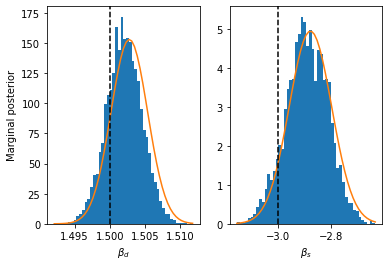

In [12]:
def gaussian_posterior(x, mean, std):
    return 1./ jax.numpy.sqrt(2. * jax.numpy.pi) * 1. / std * jax.numpy.exp(-0.5 * ((x - mean) / std) ** 2)

fig, ax = plt.subplots(ncols=2, nrows=1)

nbins = 50

theta_0_bins = ax[0].hist(samples[:, 0], bins=nbins, density=True)
ml = gaussian_posterior(theta_0_bins[1], min_res.x[0], jax.numpy.sqrt(fish_est[0, 0]))
ax[0].plot(theta_0_bins[1], ml)
ax[0].axvline(x=true_params[0], color='k', linestyle='--')

theta_1_bins = ax[1].hist(samples[:, 1], bins=nbins, density=True)
ml = gaussian_posterior(theta_1_bins[1], min_res.x[1], jax.numpy.sqrt(fish_est[1, 1]))
ax[1].plot(theta_1_bins[1], ml)
ax[1].axvline(x=true_params[1], color='k', linestyle='--')

ax[0].set_xlabel(r"$\beta_d$")
ax[1].set_xlabel(r"$\beta_s$")
ax[0].set_ylabel(r"Marginal posterior") 